In [2]:
import torch
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import html
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
nltk.download('stopwords')

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df=pd.read_csv("C:\\Users\\user\\Desktop\\project\\subset_200k_data.csv")
df.dropna()


,text,label
0,"@AndyG244 So which ones are the ""moderate"" Mus...",1.0
1,give fuck leave alone retarded administrators,1.0
2,join revolution fights freedom speech tyranny ...,1.0
3,":Excuse me, but I'd like to see a source for ...",0.0
4,` ::::: I seem to recall a source mentioning t...,0.0
...,...,...
199995,continue vandalise gonna fuck big time,1.0
199996,A 7? This bloke is utterly demented. #MKR,0.0
199997,allowed erase people harrasing messages talk page,0.0
199998,When your done with your 8 hour shift messa...,0.0


In [4]:
#delete the url, usernames,hashtags

import html
def clean_text(text):
    if isinstance(text, float):
            text = str(text)
  #remove url
    text = html.unescape(text)
    text =re.sub(r'http\S+|www\S+|https\S+',' ',text)

    # Remove usernames
    text = re.sub(r'@\w+|\#\w+', '', text)
    #text = clean(text)
    return text

# Example usage:
# Assuming dd["text"] contains mixed data types including strings and possibly other types
#df["text"] = df["text"].apply(lambda x : clean_text(x))


In [5]:
# Dataset Class for Text Classification
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len, text_preprocessing_fun=None):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.text_preprocessing_fun = text_preprocessing_fun if text_preprocessing_fun is not None else lambda x: x

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        text = self.text_preprocessing_fun(text)
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            return_attention_mask=True,
            padding='max_length',
            truncation=True
        )
        return {
            'input_ids': torch.tensor(encoding['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(encoding['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [6]:
def prepare_data_from_df(df, test_size=0.2, random_state=2022):
    # Clean and prepare text data
    df["text"] = df["text"].apply(clean_text)
    
    # Map labels to classes
    
    X=df.text.values
    y=df.label.values
    
    # Split data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    return X_train, X_val, y_train, y_val

In [7]:
def setup_cuda():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f'There are {torch.cuda.device_count()} GPU(s) available.')
        print('Device name:', torch.cuda.get_device_name(0))
    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")
    return device
device=setup_cuda()

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 2060


In [8]:
def process_df_and_get_dataloaders(df):
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    X_train, X_val, y_train, y_val = prepare_data_from_df(df)

    # Create Dataset and DataLoader for training and validation
    train_dataset = TextClassificationDataset(X_train, y_train, tokenizer, 128, clean_text)
    val_dataset = TextClassificationDataset(X_val, y_val, tokenizer, 128, clean_text)

    batch_size = 64
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    # Total number of data points in the dataset
    total_data_points = len( train_dataset)

    # Batch size (specified when you created the DataLoader)
    batch_size = train_dataloader.batch_size

    # Calculate the number of batches
    num_batches = len(train_dataloader)

    print(f"Total data points: {total_data_points}")
    print(f"Batch size: {batch_size}")
    print(f"Number of batches: {num_batches}")

    # If you need the total number of data points from the DataLoader directly (for confirmation)
    total_points_from_loader = sum(1 for _ in train_dataloader) * batch_size
    # Adjust for the last batch if it might be smaller
    total_points_from_loader_adjusted = total_points_from_loader - batch_size + (total_data_points % batch_size or batch_size)
    print(f"Calculated total data points from DataLoader: {total_points_from_loader_adjusted}")
    # Total number of data points in the dataset
    total_data_points = len(val_dataset)

    # Batch size (specified when you created the DataLoader)
    batch_size = val_dataloader.batch_size

    # Calculate the number of batches
    num_batches = len(val_dataloader)

    print(f"Total data points: {total_data_points}")
    print(f"Batch size: {batch_size}")
    print(f"Number of batches: {num_batches}")

    # If you need the total number of data points from the DataLoader directly (for confirmation)
    total_points_from_loader = sum(1 for _ in val_dataloader) * batch_size
    # Adjust for the last batch if it might be smaller
    total_points_from_loader_adjusted = total_points_from_loader - batch_size + (total_data_points % batch_size or batch_size)
    print(f"Calculated total data points from DataLoader: {total_points_from_loader_adjusted}")

    return train_dataloader, val_dataloader

In [9]:
train_dataloader, val_dataloader = process_df_and_get_dataloaders(df)

Total data points: 160000
Batch size: 64
Number of batches: 2500
Calculated total data points from DataLoader: 160000
Total data points: 40000
Batch size: 64
Number of batches: 625
Calculated total data points from DataLoader: 40000


In [19]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False, version="bert"):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = AutoModel.from_pretrained("bert-base-uncased") 
        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: total: 0 ns
Wall time: 0 ns


In [11]:
from transformers import AdamW, get_linear_schedule_with_warmup

from torch.optim import SparseAdam, Adam
def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)
    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(params=list(bert_classifier.parameters()),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [12]:
import random
import time
import torch
import torch.nn as nn
from transformers import AutoModel

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

# Train function
def train(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs=4, evaluation=False):
    train_losses = []
    val_losses = []
    val_accuracies = []
    train_accuracies = []

    print("Start training...\n")
    for epoch_i in range(epochs):
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)
        t0_epoch, t0_batch = time.time(), time.time()
        total_loss, batch_loss, batch_counts = 0, 0, 0
        total_correct, total_samples = 0, 0
        model.train()
        for step, batch in enumerate(train_dataloader):
            b_input_ids = batch['input_ids'].to(device)
            b_attn_mask = batch['attention_mask'].to(device)
            b_labels = batch['labels'].to(device)
            model.zero_grad()
            logits = model(b_input_ids, b_attn_mask)
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            batch_counts += 1
            preds = torch.argmax(logits, dim=1).flatten()
            correct = (preds == b_labels).sum().item()
            total_correct += correct
            total_samples += b_labels.size(0)
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()
        avg_train_loss = total_loss / len(train_dataloader)
        train_accuracy = total_correct / total_samples * 100
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        print("-"*70)
        if evaluation == True:
            val_loss, val_accuracy = evaluate(model, val_dataloader)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    print("Training complete!")
    return train_losses, val_losses, val_accuracies, train_accuracies

def evaluate(model, val_dataloader):
    model.eval()
    val_accuracy = []
    val_loss = []
    for batch in val_dataloader:
        b_input_ids = batch['input_ids'].to(device)
        b_attn_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())
        preds = torch.argmax(logits, dim=1).flatten()
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    return val_loss, val_accuracy
   
         

In [13]:

from sklearn.model_selection import train_test_split, StratifiedKFold
import html
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score
from transformers import AdamW, get_linear_schedule_with_warmup

# Calculate metrics
def calculate_metrics(model, dataloader, device):
    true_labels = []
    predictions = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    accuracy = np.mean(np.array(predictions) == np.array(true_labels))
    precision = precision_score(true_labels, predictions, average='macro')
    recall = recall_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')
    return accuracy, precision, recall, f1

# Save model
def save_model(model, optimizer, scheduler, save_path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, save_path)

# Cross-validation
def cross_val_evaluate(ModelClass, dataset, k=4):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(dataset.texts, dataset.labels)):
        print(f'Fold {fold + 1}/{k}')
        train_texts = [dataset.texts[i] for i in train_idx]
        train_labels = [dataset.labels[i] for i in train_idx]
        val_texts = [dataset.texts[i] for i in val_idx]
        val_labels = [dataset.labels[i] for i in val_idx]
        train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, 128, clean_text)
        val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, 128, clean_text)
        train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=64)
        
        # Initialize the model, optimizer, and scheduler
        model = ModelClass()
        optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
        total_steps = len(train_dataloader) * 4
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
        
        model.to(device)
        
        # Train the model
        train_losses, val_losses, val_accuracies, train_accuracies = train(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs=3, evaluation=True)
        
        # Validate the model
        val_accuracy, _, _, _ = calculate_metrics(model, val_dataloader, device)
        accuracies.append(val_accuracy)
        print(f'Fold {fold + 1} Validation Accuracy: {val_accuracy * 100:.2f}%')
        
        # Save the model for this fold
        model_save_path = f'bert_classifier_fold_{fold + 1}.pth'
        save_model(model, optimizer, scheduler, model_save_path)
        print(f'Model saved for fold {fold + 1} at {model_save_path}')
    
    # Calculate and print the average accuracy
    avg_accuracy = np.mean(accuracies)
    print(f'Average Cross-Validation Accuracy: {avg_accuracy * 100:.2f}%')

In [14]:
# Prepare the data
df["text"] = df["text"].apply(clean_text)
texts = df["text"].values
labels = df["label"].values

# Create the initial dataset
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
dataset = TextClassificationDataset(texts, labels, tokenizer, 128, clean_text)

# Perform cross-validation
cross_val_evaluate(BertClassifier, dataset, k=10)

Fold 1/10


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


   1    |   20    |   0.571059   |     -      |     -     |   24.32  
   1    |   40    |   0.426882   |     -      |     -     |   23.91  
   1    |   60    |   0.383747   |     -      |     -     |   23.90  
   1    |   80    |   0.337318   |     -      |     -     |   23.73  
   1    |   100   |   0.346420   |     -      |     -     |   23.72  
   1    |   120   |   0.356940   |     -      |     -     |   23.72  
   1    |   140   |   0.336864   |     -      |     -     |   23.70  
   1    |   160   |   0.332202   |     -      |     -     |   23.83  
   1    |   180   |   0.295210   |     -      |     -     |   24.00  
   1    |   200   |   0.341436   |     -      |     -     |   24.02  
   1    |   220   |   0.325901   |     -      |     -     |   22.99  
   1    |   240   |   0.323054   |     -      |     -     |   23.55  
   1    |   260   |   0.323664   |     -      |     -     |   23.65  
   1    |   280   |   0.308464   |     -      |     -     |   23.85  
   1    |   300   | 

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.553831   |     -      |     -     |   18.01  
   1    |   40    |   0.389995   |     -      |     -     |   17.14  
   1    |   60    |   0.381064   |     -      |     -     |   17.18  
   1    |   80    |   0.356109   |     -      |     -     |   17.16  
   1    |   100   |   0.338450   |     -      |     -     |   17.16  
   1    |   120   |   0.342239   |     -      |     -     |   17.15  
   1    |   140   |   0.326398   |     -      |     -     |   17.11  
   1    |   160   |   0.329108   |     -      |     -     |   17.11  
   1    |   180   |   0.320836   |     -      |     -     |   17.10  
   1    |   200   |   0.343760   |     -      |     -     |   17.10  
   1    |   220   |   0.342532   |     -      |     -     |   17.13  
   1    |   240   |   0.331608   |     -      |     -     |   17.16  


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.575701   |     -      |     -     |   18.03  
   1    |   40    |   0.437886   |     -      |     -     |   17.17  
   1    |   60    |   0.375572   |     -      |     -     |   17.14  
   1    |   80    |   0.362785   |     -      |     -     |   17.11  
   1    |   100   |   0.335214   |     -      |     -     |   17.10  
   1    |   120   |   0.349165   |     -      |     -     |   17.12  
   1    |   140   |   0.315531   |     -      |     -     |   17.10  
   1    |   160   |   0.348518   |     -      |     -     |   17.12  
   1    |   180   |   0.343334   |     -      |     -     |   17.10  
   1    |   200   |   0.310735   |     -      |     -     |   17.12  
   1    |   220   |   0.315431   |     -      |     -     |   17.13  
   1    |   240   |   0.330332   |     -      |     -     |   17.15  


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.588270   |     -      |     -     |   17.98  
   1    |   40    |   0.442595   |     -      |     -     |   17.08  
   1    |   60    |   0.381987   |     -      |     -     |   17.08  
   1    |   80    |   0.347240   |     -      |     -     |   17.08  
   1    |   100   |   0.355609   |     -      |     -     |   17.08  
   1    |   120   |   0.360850   |     -      |     -     |   17.12  
   1    |   140   |   0.331715   |     -      |     -     |   17.11  
   1    |   160   |   0.332838   |     -      |     -     |   17.10  
   1    |   180   |   0.326267   |     -      |     -     |   17.09  
   1    |   200   |   0.319600   |     -      |     -     |   17.10  
   1    |   220   |   0.323478   |     -      |     -     |   17.10  
   1    |   240   |   0.348426   |     -      |     -     |   17.11  


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.563968   |     -      |     -     |   17.94  
   1    |   40    |   0.418263   |     -      |     -     |   17.08  
   1    |   60    |   0.404408   |     -      |     -     |   17.07  
   1    |   80    |   0.376952   |     -      |     -     |   17.08  
   1    |   100   |   0.345277   |     -      |     -     |   17.07  
   1    |   120   |   0.328616   |     -      |     -     |   17.06  
   1    |   140   |   0.336487   |     -      |     -     |   17.07  
   1    |   160   |   0.344582   |     -      |     -     |   17.08  
   1    |   180   |   0.308368   |     -      |     -     |   17.08  
   1    |   200   |   0.349351   |     -      |     -     |   17.04  
   1    |   220   |   0.330888   |     -      |     -     |   17.03  
   1    |   240   |   0.318111   |     -      |     -     |   17.05  


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.527198   |     -      |     -     |   17.95  
   1    |   40    |   0.413015   |     -      |     -     |   17.05  
   1    |   60    |   0.395412   |     -      |     -     |   17.02  
   1    |   80    |   0.348898   |     -      |     -     |   17.04  
   1    |   100   |   0.396934   |     -      |     -     |   17.05  
   1    |   120   |   0.341244   |     -      |     -     |   17.07  
   1    |   140   |   0.339751   |     -      |     -     |   17.06  
   1    |   160   |   0.337553   |     -      |     -     |   17.06  
   1    |   180   |   0.346445   |     -      |     -     |   17.04  
   1    |   200   |   0.305800   |     -      |     -     |   17.04  
   1    |   220   |   0.320478   |     -      |     -     |   17.03  
   1    |   240   |   0.275338   |     -      |     -     |   17.03  


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.541976   |     -      |     -     |   17.93  
   1    |   40    |   0.438680   |     -      |     -     |   17.07  
   1    |   60    |   0.407814   |     -      |     -     |   17.09  
   1    |   80    |   0.353561   |     -      |     -     |   17.08  
   1    |   100   |   0.353068   |     -      |     -     |   17.07  
   1    |   120   |   0.357739   |     -      |     -     |   17.04  
   1    |   140   |   0.344761   |     -      |     -     |   17.03  
   1    |   160   |   0.354641   |     -      |     -     |   17.02  
   1    |   180   |   0.329491   |     -      |     -     |   17.03  
   1    |   200   |   0.339255   |     -      |     -     |   17.03  
   1    |   220   |   0.339294   |     -      |     -     |   17.07  
   1    |   240   |   0.331056   |     -      |     -     |   17.08  


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.551761   |     -      |     -     |   23.72  
   1    |   40    |   0.408766   |     -      |     -     |   22.31  
   1    |   60    |   0.385464   |     -      |     -     |   22.26  
   1    |   80    |   0.365431   |     -      |     -     |   22.28  
   1    |   100   |   0.364954   |     -      |     -     |   22.17  
   1    |   120   |   0.333976   |     -      |     -     |   22.25  
   1    |   140   |   0.356953   |     -      |     -     |   22.24  
   1    |   160   |   0.315530   |     -      |     -     |   22.24  
   1    |   180   |   0.330646   |     -      |     -     |   22.44  
   1    |   200   |   0.338063   |     -      |     -     |   22.22  
   1    |   220   |   0.328061   |     -      |     -     |   22.24  
   1    |   240   |   0.320018   |     -      |     -     |   22.23  


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.533807   |     -      |     -     |   25.32  
   1    |   40    |   0.390763   |     -      |     -     |   23.88  
   1    |   60    |   0.339857   |     -      |     -     |   23.99  
   1    |   80    |   0.372360   |     -      |     -     |   23.92  
   1    |   100   |   0.343243   |     -      |     -     |   23.89  
   1    |   120   |   0.329517   |     -      |     -     |   24.12  
   1    |   140   |   0.322621   |     -      |     -     |   24.29  
   1    |   160   |   0.327697   |     -      |     -     |   23.50  
   1    |   180   |   0.302631   |     -      |     -     |   23.96  
   1    |   200   |   0.313297   |     -      |     -     |   23.94  
   1    |   220   |   0.332842   |     -      |     -     |   23.95  
   1    |   240   |   0.320932   |     -      |     -     |   24.13  


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.565100   |     -      |     -     |   17.91  
   1    |   40    |   0.416680   |     -      |     -     |   17.06  
   1    |   60    |   0.372564   |     -      |     -     |   17.07  
   1    |   80    |   0.373104   |     -      |     -     |   17.08  
   1    |   100   |   0.385836   |     -      |     -     |   17.04  
   1    |   120   |   0.370500   |     -      |     -     |   17.03  
   1    |   140   |   0.353338   |     -      |     -     |   17.06  
   1    |   160   |   0.309622   |     -      |     -     |   17.03  
   1    |   180   |   0.316416   |     -      |     -     |   17.03  
   1    |   200   |   0.345525   |     -      |     -     |   17.03  
   1    |   220   |   0.304605   |     -      |     -     |   17.04  
   1    |   240   |   0.309502   |     -      |     -     |   17.03  


In [15]:
# Load the testing dataset
test_df = pd.read_csv("C:\\Users\\user\\Desktop\\project\\extra_data.csv")
# Sample a fixed number of rows (e.g., 100 rows) from your test DataFrame randomly
test_df = test_df.sample(n=20000, random_state=42)  # Adjust n as needed

test_df = test_df.dropna()
print(test_df.shape)

# Preprocess the text data in the test dataset
test_df["text"] = test_df["text"].apply(clean_text)

# Tokenize and create a DataLoader for the test data
def prepare_data_for_testing(df, tokenizer, max_len=128):
    texts = df.text.values
    labels = df.label.values  # Make sure your testing data also has labels for evaluation

    # Create Dataset
    test_dataset = TextClassificationDataset(texts, labels, tokenizer, max_len, clean_text)

    # Create DataLoader
    test_dataloader = DataLoader(test_dataset, batch_size=64)  # Adjust batch size as necessary
    total_data_points = len( test_dataset)

    # Batch size (specified when you created the DataLoader)
    batch_size =test_dataloader.batch_size

        # Calculate the number of batchesq
    num_batches = len(test_dataloader)

    print(f"Total data points: {total_data_points}")
    print(f"Batch size: {batch_size}")
    print(f"Number of batches: {num_batches}")

        # If you need the total number of data points from the DataLoader directly (for confirmation)
    total_points_from_loader = sum(1 for _ in test_dataloader) * batch_size
        # Adjust for the last batch if it might be smaller
    total_points_from_loader_adjusted = total_points_from_loader - batch_size + (total_data_points % batch_size or batch_size)
    print(f"Calculated total data points from DataLoader: {total_points_from_loader_adjusted}")
        # Total number of data points in the dataset

    return test_dataloader

test_dataloader = prepare_data_for_testing(test_df, tokenizer)


(19995, 2)
Total data points: 19995
Batch size: 64
Number of batches: 313
Calculated total data points from DataLoader: 19995


label
0.0    10062
1.0     9933
Name: count, dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_12164\1785527301.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution_test.index, y=class_distribution_test.values, palette='viridis')


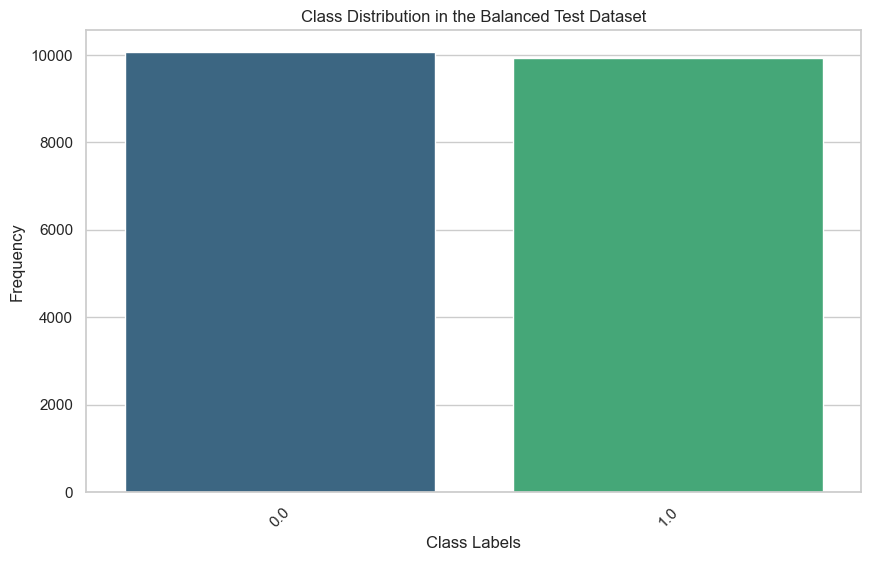

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns


class_distribution_test = test_df['label'].value_counts()
print(class_distribution_test)
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size
class_distribution = test_df['label'].value_counts()
sns.barplot(x=class_distribution_test.index, y=class_distribution_test.values, palette='viridis')

# Adding title and labels to the plot
plt.title('Class Distribution in the Balanced Test Dataset')
plt.xlabel('Class Labels')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.xticks(rotation=45)  # Rotate the class names if needed

# Show the plot
plt.show()


In [21]:
def load_model(save_path):
    model = BertClassifier()
    checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    return model

In [22]:
# Function to evaluate a model on test data
def evaluate_on_test(model, test_dataloader, device):
    model.eval()  # Set the model to evaluation mode
    total_accuracy = 0
    all_preds = []
    all_labels = []

    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch.values())
        b_input_ids, b_attn_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, b_attn_mask)
        logits = outputs
        preds = torch.argmax(logits, dim=1).flatten()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(b_labels.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    return accuracy, precision, recall, f1 , all_preds, all_labels

Fold 1 Test Accuracy: 92.63%
Fold 1 Test Precision: 0.93
Fold 1 Test Recall: 0.93
Fold 1 Test F1 Score: 0.93
Fold 2 Test Accuracy: 92.79%
Fold 2 Test Precision: 0.93
Fold 2 Test Recall: 0.93
Fold 2 Test F1 Score: 0.93
Fold 3 Test Accuracy: 93.15%
Fold 3 Test Precision: 0.93
Fold 3 Test Recall: 0.93
Fold 3 Test F1 Score: 0.93
Fold 4 Test Accuracy: 92.94%
Fold 4 Test Precision: 0.93
Fold 4 Test Recall: 0.93
Fold 4 Test F1 Score: 0.93
Fold 5 Test Accuracy: 92.92%
Fold 5 Test Precision: 0.93
Fold 5 Test Recall: 0.93
Fold 5 Test F1 Score: 0.93
Fold 6 Test Accuracy: 92.94%
Fold 6 Test Precision: 0.93
Fold 6 Test Recall: 0.93
Fold 6 Test F1 Score: 0.93
Fold 7 Test Accuracy: 92.88%
Fold 7 Test Precision: 0.93
Fold 7 Test Recall: 0.93
Fold 7 Test F1 Score: 0.93
Fold 8 Test Accuracy: 92.82%
Fold 8 Test Precision: 0.93
Fold 8 Test Recall: 0.93
Fold 8 Test F1 Score: 0.93
Fold 9 Test Accuracy: 92.87%
Fold 9 Test Precision: 0.93
Fold 9 Test Recall: 0.93
Fold 9 Test F1 Score: 0.93
Fold 10 Test Accura

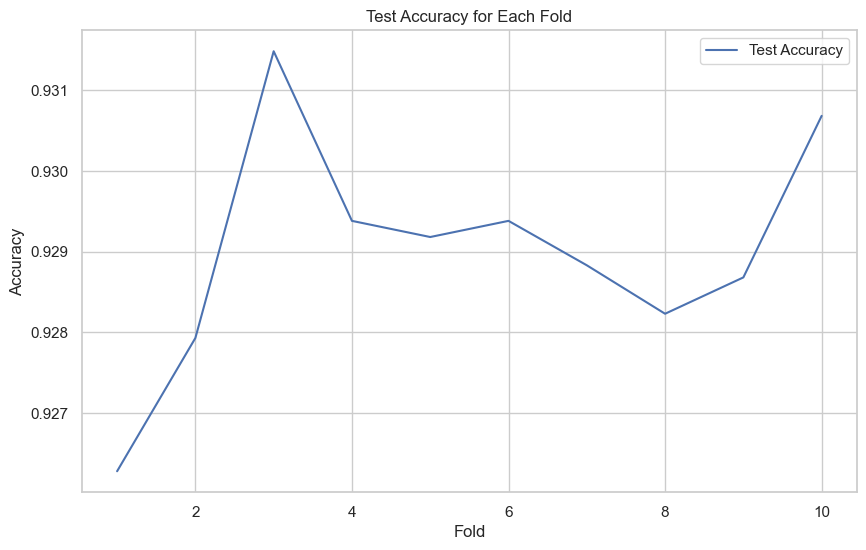

In [23]:
import matplotlib.pyplot as plt

# List to store test accuracies for each fold
test_accuracies = []
folds = 10  # Adjust this according to the number of folds

for fold in range(1, folds + 1):
    model_save_path = f'bert_classifier_fold_{fold}.pth'
    model = load_model(model_save_path)
    test_accuracy, test_precision, test_recall, test_f1 , pred ,Tlabel= evaluate_on_test(model, test_dataloader, device)
    test_accuracies.append(test_accuracy)
    print(f'Fold {fold} Test Accuracy: {test_accuracy * 100:.2f}%')
    print(f'Fold {fold} Test Precision: {test_precision:.2f}')
    print(f'Fold {fold} Test Recall: {test_recall:.2f}')
    print(f'Fold {fold} Test F1 Score: {test_f1:.2f}')

# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, folds + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for Each Fold')
plt.legend()
plt.show()


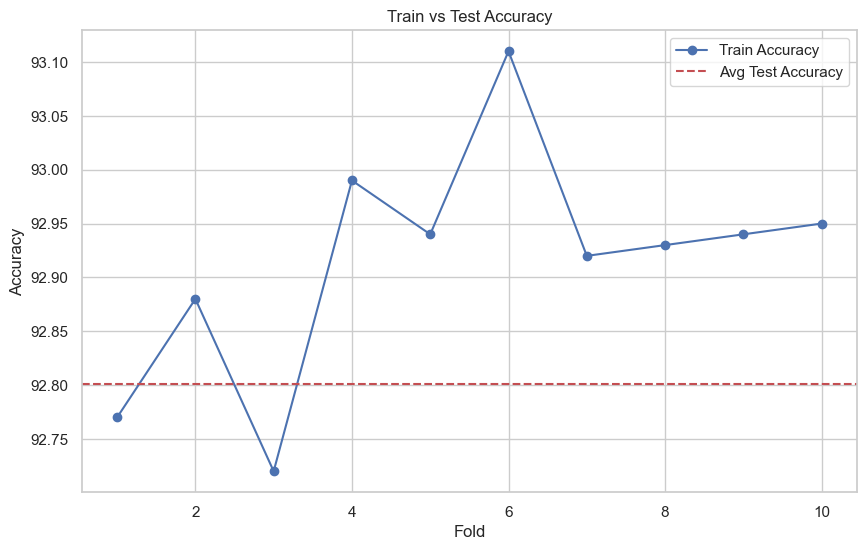

In [24]:
import matplotlib.pyplot as plt
# Assuming train_accuracies is a list of training accuracies for each fold
# Assuming test_accuracies is a list of test accuracies for each fold
train_accuracies = [92.77, 92.88, 92.72, 92.99, 92.94, 93.11, 92.92, 92.93, 92.94, 92.95]
test_accuracies = [92.63, 92.79, 93.15, 92.94, 92.92, 92.94, 92.88, 92.82, 92.87, 92.07]

# Calculate the average test accuracy
avg_test_accuracy = sum(test_accuracies) / len(test_accuracies)

# Plotting
epochs = range(1, len(train_accuracies) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.axhline(y=avg_test_accuracy, color='r', linestyle='--', label='Avg Test Accuracy')

plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.legend()

plt.show()

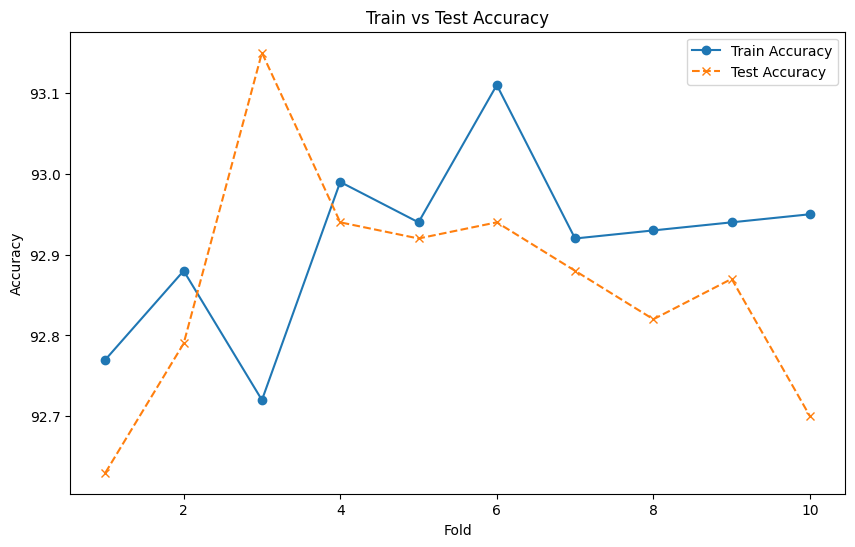

In [3]:
import matplotlib.pyplot as plt
# Assuming train_accuracies is a list of training accuracies for each fold
# Assuming test_accuracies is a list of test accuracies for each fold
train_accuracies = [92.77, 92.88, 92.72, 92.99, 92.94, 93.11, 92.92, 92.93, 92.94, 92.95]
test_accuracies = [92.63, 92.79, 93.15, 92.94, 92.92, 92.94, 92.88, 92.82, 92.87, 92.70]

folds = range(1, len(train_accuracies) + 1)

plt.figure(figsize=(10, 6))
plt.plot(folds, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(folds, test_accuracies, label='Test Accuracy', marker='x', linestyle='--')

plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(true_labels, predictions))
print(confusion_matrix(true_labels, predictions))


              precision    recall  f1-score   support

           0       0.93      0.89      0.91     10062
           1       0.90      0.93      0.92      9933

    accuracy                           0.91     19995
   macro avg       0.92      0.91      0.91     19995
weighted avg       0.92      0.91      0.91     19995

[[9004 1058]
 [ 652 9281]]


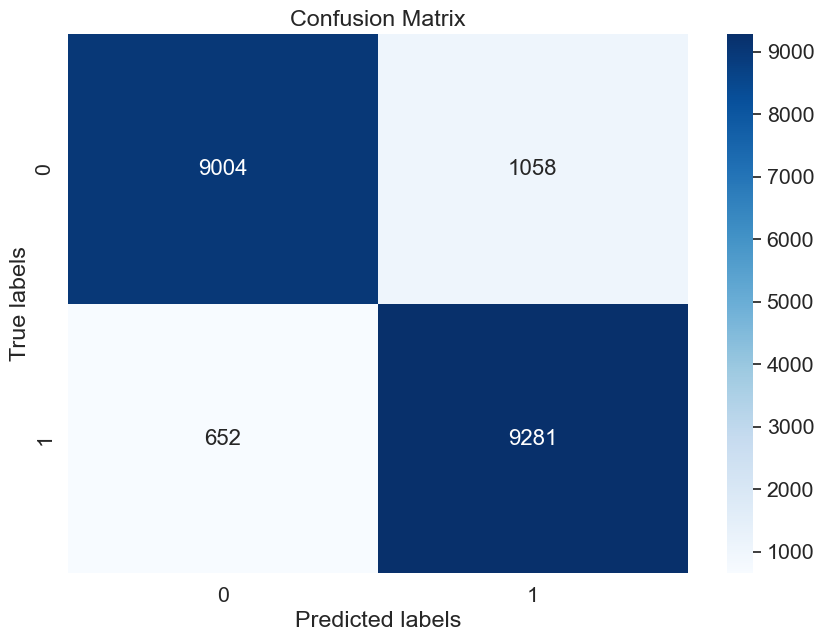

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming `true_labels` and `predictions` are already defined
conf_matrix = confusion_matrix(true_labels, predictions)

# Plotting using Seaborn
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt='g', cmap="Blues")  # fmt='g' avoids scientific notation

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model = BertClassifier()
checkpoint = torch.load('bert_classifier_fold_1.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

# Assuming the tokenizer is already defined as `tokenizer`
# Prepare the dataloaders again if not already done
train_dataloader, val_dataloader = process_df_and_get_dataloaders(df)

# Calculate metrics function
def calculate_metrics(model, dataloader, device):
    model.eval()
    true_labels = []
    predictions = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    accuracy = np.mean(np.array(predictions) == np.array(true_labels))
    precision = precision_score(true_labels, predictions, average='macro')
    recall = recall_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')
    return accuracy, precision, recall, f1

# Calculate metrics for the training dataset
train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(model, train_dataloader, device)
print(f"Training Metrics:\nAccuracy: {train_accuracy * 100:.2f}%\nPrecision: {train_precision:.2f}\nRecall: {train_recall:.2f}\nF1 Score: {train_f1:.2f}")

# Calculate metrics for the validation dataset
val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(model, val_dataloader, device)
print(f"Validation Metrics:\nAccuracy: {val_accuracy * 100:.2f}%\nPrecision: {val_precision:.2f}\nRecall: {val_recall:.2f}\nF1 Score: {val_f1:.2f}")

0.9160693448908152


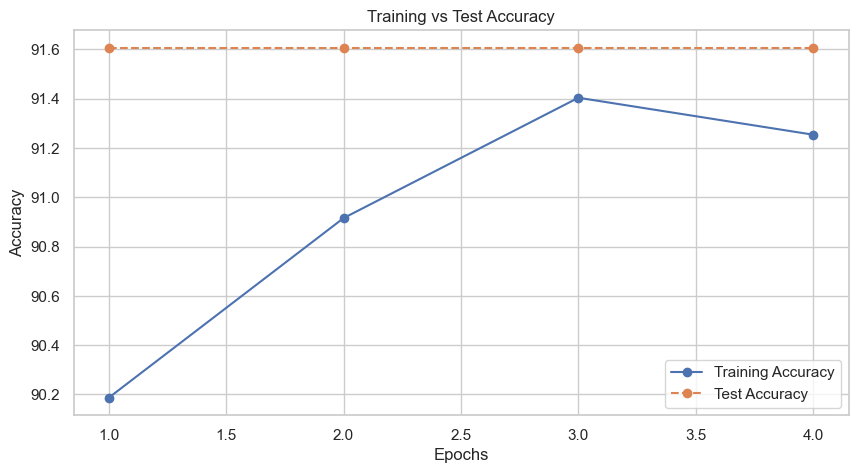

In [ ]:
import matplotlib.pyplot as plt
print(test_accuracy)
# Generate a list of epochs based on the length of your training accuracies
epochs = list(range(1, len(val_accuracies) + 1))
test_accuracies = [test_accuracy*100] * len(val_accuracies)

plt.figure(figsize=(10, 5))
plt.plot(epochs, val_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

def load_model(model_path):
    # Create a new model instance
    model = BertClassifier()
    # Load the saved state
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

model_path = 'C:\\Users\\HP\\OneDrive\\Desktop\\GRAD PROJ\\cyber_ENmodel_checkpoint.pth'
model = load_model(model_path)
model.eval()  # Set the model to evaluation mode



BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(model, dataloader, device):
    true_labels = []
    predictions = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = np.mean(np.array(predictions) == np.array(true_labels))
    precision = precision_score(true_labels, predictions, average='macro')
    recall = recall_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')
    
    return accuracy, precision, recall, f1

# Assuming you have a dataloader for your training data and a device setup
model = BertClassifier()
checkpoint = torch.load('C:\\Users\\HP\\OneDrive\\Desktop\\GRAD PROJ\\cyber_ENmodel_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)  # Move model to the appropriate device

train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(model, train_dataloader, device)
print(f"Training Metrics:\nAccuracy: {train_accuracy * 100:.2f}%\nPrecision: {train_precision:.2f}\nRecall: {train_recall:.2f}\nF1 Score: {train_f1:.2f}")


Training Metrics:
Accuracy: 98.81%
Precision: 0.99
Recall: 0.99
F1 Score: 0.99


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


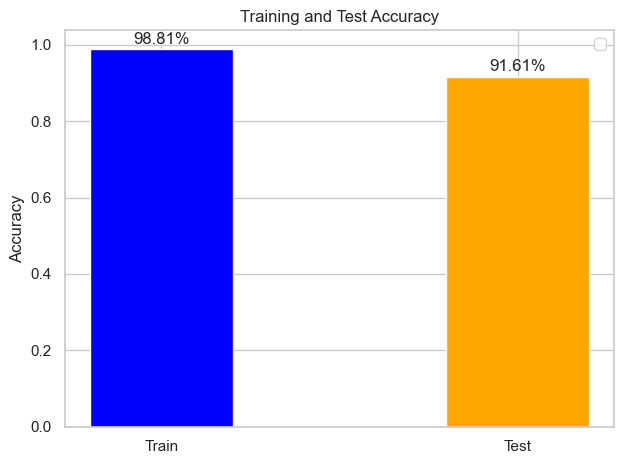

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the accuracies to plot
accuracies = ['Train',  'Test']
accuracy_values = [train_accuracy,  test_accuracy]

# Define the x-axis positions
x = np.arange(len(accuracies))

fig, ax = plt.subplots()

# Plot the accuracies
rects = ax.bar(x, accuracy_values, width=0.4, color=['blue', 'orange'])

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Training and Test Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(accuracies)
ax.legend()

# Attach a text label above each bar in rects, displaying its height.
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height*100:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

fig.tight_layout()

plt.show()
